<p style="text-align:center;font-size:30px ;font-weight: bold; line-height: 40px;"> EDA for GTFS-R data <p/>
<p style="text-align:center;  line-height: 0px;font-weight: bold;"> Nov 3, 2021<p/>

<h2> Understanding data</h2>
<h4>This dataset has five high freq  routes during four days</h4>

<h6>Columns description:</h6>


<ul>
    <li>Latitude - degrees North, in the WGS-84 coordinate system</li>
    <li>Longitude - degrees East, in the WGS-84 coordinate system</li>
    <li>Bearing - direction that the vehicle is facing</li>
    <li>Odometer - the distance that the vehicle has travelled</li>
    <li>Speed - momentary speed measured by the vehicle, in meters per second</li>
    </ul>



In [1]:
import json
import pandas as pd  # data processing
import numpy as np  # linear algebra
import glob  # find files recursively
import re
from pandas import DataFrame
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import calendar

import folium as fl
import seaborn as sns
from geopy.distance import GreatCircleDistance



import geopandas

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

from branca.element import Figure

%matplotlib inline
sns.set()

import datetime

In [2]:
df = pd.read_csv('FINAL_DATA.csv', low_memory=False)

In [3]:
df.head()

V_ID   TripId   RouteId Trip_StartTime  \
0  43054_180769313_2459_440_1  1358332  2459_440       12:14:00   
1  43054_180767478_2459_440_1  1252560  2459_440       11:52:00   
2  43054_187614839_2459_440_1  1209433  2459_440       12:30:00   
3  43054_180768965_2459_440_1  1358330  2459_440       11:44:00   
4  43054_180768967_2459_440_1  1252564  2459_440       12:52:00   

   Trip_StartDate  schedule_relationship  VP_Latitude  VP_Longitude  \
0        20210517                      0   -33.887900     151.16745   
1        20210517                      0   -33.888294     151.16277   
2        20210517                      0   -33.877396     151.15670   
3        20210517                      0   -33.890537     151.24315   
4        20210517                      0   -33.890537     151.24315   

   VP_Bearing  VP_Speed  V_Timestamp  V_occupancy_status  
0          90       0.0   1621218894                   1  
1         280      12.2   1621218894                   1  
2         265       6.0   1621218874                   1  
3         108       2.4   1621218895                   1  
4         108       2.4   1621218895                   1

In [4]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

In [5]:
df.shape

(1751248, 12)

In [6]:
#get summary of Vivante dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751248 entries, 0 to 1751247
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   V_ID                   object 
 1   TripId                 object 
 2   RouteId                object 
 3   Trip_StartTime         object 
 4   Trip_StartDate         int64  
 5   schedule_relationship  int64  
 6   VP_Latitude            float64
 7   VP_Longitude           float64
 8   VP_Bearing             int64  
 9   VP_Speed               float64
 10  V_Timestamp            int64  
 11  V_occupancy_status     int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 160.3+ MB


In [7]:
df.nunique()

V_ID                       1907
TripId                     1693
RouteId                       5
Trip_StartTime              836
Trip_StartDate                5
schedule_relationship         2
VP_Latitude               78814
VP_Longitude              21800
VP_Bearing                  361
VP_Speed                    279
V_Timestamp              274254
V_occupancy_status            3
dtype: int64

In [8]:
df.describe()

Trip_StartDate  schedule_relationship   VP_Latitude  VP_Longitude  \
count    1.751248e+06           1.751248e+06  1.751248e+06  1.751248e+06   
mean     2.021052e+07           4.081661e-03 -3.382762e+01  1.511845e+02   
std      1.203533e+00           6.375738e-02  8.103513e-02  1.345671e-01   
min      2.021052e+07           0.000000e+00 -3.398131e+01  1.508493e+02   
25%      2.021052e+07           0.000000e+00 -3.388782e+01  1.511669e+02   
50%      2.021052e+07           0.000000e+00 -3.386398e+01  1.512275e+02   
75%      2.021052e+07           0.000000e+00 -3.378565e+01  1.512791e+02   
max      2.021052e+07           1.000000e+00 -3.359213e+01  1.513350e+02   

         VP_Bearing      VP_Speed   V_Timestamp  V_occupancy_status  
count  1.751248e+06  1.751248e+06  1.751248e+06        1.751248e+06  
mean   1.713094e+02  6.009630e+00  1.621379e+09        1.064172e+00  
std    1.064446e+02  5.799837e+00  1.000441e+05        2.472258e-01  
min    0.000000e+00  0.000000e+00  1.621209e+09        1.000000e+00  
25%    8.500000e+01  0.000000e+00  1.621297e+09        1.000000e+00  
50%    1.780000e+02  5.400000e+00  1.621383e+09        1.000000e+00  
75%    2.670000e+02  1.060000e+01  1.621469e+09        1.000000e+00  
max    3.600000e+02  2.800000e+01  1.621555e+09        3.000000e+00

In [9]:
df.describe(include=object)

V_ID   TripId   RouteId Trip_StartTime
count                      1751248  1751248   1751248        1751248
unique                        1907     1693         5            836
top     11954_206347272_2440_199_1  1322276  2441_333       16:40:00
freq                          1928     1928    403648          11590

In [10]:
def check_missing(df):
    # Check the percentage of Nan in dataset
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/len(df)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data 

In [11]:
check_missing(df)

Total  Percent
V_ID                       0      0.0
TripId                     0      0.0
RouteId                    0      0.0
Trip_StartTime             0      0.0
Trip_StartDate             0      0.0
schedule_relationship      0      0.0
VP_Latitude                0      0.0
VP_Longitude               0      0.0
VP_Bearing                 0      0.0
VP_Speed                   0      0.0
V_Timestamp                0      0.0
V_occupancy_status         0      0.0

In [12]:
df['trip_hour'] = pd.to_datetime(df['Trip_StartTime']).dt.hour

In [13]:
df['Trip_StartTime'] =  pd.to_datetime(df['Trip_StartTime'])

/home/qamar/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_hour', ylabel='Density'>

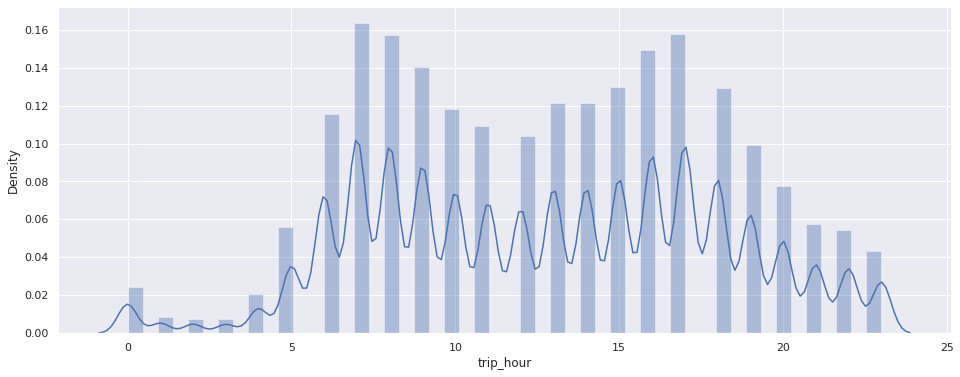

In [14]:
fig = plt.figure(figsize =(16, 6))
sns.distplot(df['trip_hour'])

In [15]:
# Check duplicated records
print('Number of duplicated records: ', df.duplicated(keep='first').sum())

print('Percentage of duplicate records: ', df.duplicated(keep='first').sum()/len(df))

Number of duplicated records:  305232
Percentage of duplicate records:  0.17429398920084418


/home/qamar/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


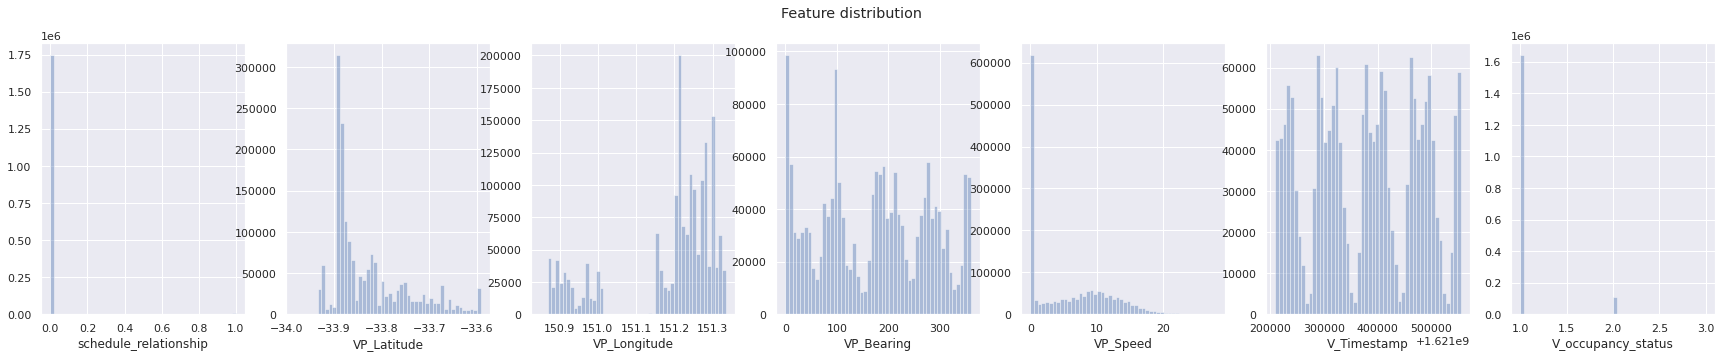

In [16]:
def plot_distribution(df,**kwargs ):
    columns = ['schedule_relationship','VP_Latitude','VP_Longitude', 
               'VP_Bearing', 'VP_Speed', 'V_Timestamp','V_occupancy_status']
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.distplot(df[col], ax=axs,**kwargs)
        fig.suptitle('Feature distribution')
    
plot_distribution(df, kde=False)

In [17]:
df['day'] = df['Trip_StartDate'] % 100

In [18]:
print(df[df['day'] == 17]['V_ID'].nunique())
print(df[df['day'] == 18]['V_ID'].nunique())
print(df[df['day'] == 19]['V_ID'].nunique())
print(df[df['day'] == 20]['V_ID'].nunique())

1107
1558
1568
1554


In [19]:
# Generate GeometryArray of shapely Point geometries from x, y(, z) coordinates.
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.VP_Longitude, df.VP_Latitude))

Plot a GeoDataFrame.

<ul>
    <li>naturalearth_lowres: contours of countries<li>
naturalearth_cities: positions of cities

/home/qamar/Downloads/Or/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


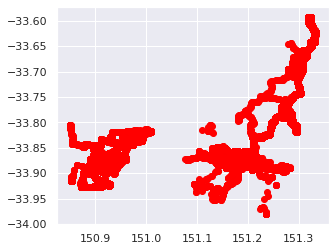

In [20]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# restrict to Australia.
ax = world[world.continent == 'Australia'].plot(
    color='white', edgecolor='black')

# plot GeoDataFrame
gdf.plot(ax=ax, color='red')

plt.show()

In [21]:
bus_locations =df[df['TripId'] == "1322276"]


In [22]:
bus_locations.head()

V_ID   TripId   RouteId      Trip_StartTime  \
32383  11954_206347272_2440_199_1  1322276  2440_199 2021-11-03 17:00:00   
32512  11954_206347272_2440_199_1  1322276  2440_199 2021-11-03 17:00:00   
32641  11954_206347272_2440_199_1  1322276  2440_199 2021-11-03 17:00:00   
32772  11954_206347272_2440_199_1  1322276  2440_199 2021-11-03 17:00:00   
32897  11954_206347272_2440_199_1  1322276  2440_199 2021-11-03 17:00:00   

       Trip_StartDate  schedule_relationship  VP_Latitude  VP_Longitude  \
32383        20210517                      0    -33.75445     151.28407   
32512        20210517                      0    -33.75445     151.28407   
32641        20210517                      0    -33.75445     151.28407   
32772        20210517                      0    -33.75439     151.28412   
32897        20210517                      0    -33.77111     151.26837   

       VP_Bearing  VP_Speed  V_Timestamp  V_occupancy_status  trip_hour  day  \
32383          35       0.0   1621236779                   1         17   17   
32512          35       0.0   1621236779                   1         17   17   
32641          35       0.1   1621236794                   1         17   17   
32772          36       0.0   1621236816                   1         17   17   
32897          13       6.4   1621236176                   2         17   17   

                          geometry  
32383  POINT (151.28407 -33.75445)  
32512  POINT (151.28407 -33.75445)  
32641  POINT (151.28407 -33.75445)  
32772  POINT (151.28412 -33.75439)  
32897  POINT (151.26837 -33.77111)

In [23]:
#pass the mean of the latitude and longitude coordinates to centre the map there
m1 = folium.Map(location=[bus_locations.VP_Latitude.mean(),
                           bus_locations.VP_Longitude.mean()],
                 zoom_start=11, control_scale=True)



In [24]:
# Adding points to the map
for index, location_info in bus_locations.iterrows():
    folium.Marker([location_info["VP_Latitude"], location_info["VP_Longitude"]], 
                  popup=location_info["TripId"]).add_to(m1)

m1

In [25]:
fig2=Figure(width=600,height=350)
fig2.add_child(m1)
folium.TileLayer('Stamen Terrain').add_to(m1)
folium.TileLayer('Stamen Toner').add_to(m1)
folium.TileLayer('Stamen Water Color').add_to(m1)
folium.TileLayer('cartodbpositron').add_to(m1)
folium.TileLayer('cartodbdark_matter').add_to(m1)
folium.LayerControl().add_to(m1)
m1

In [26]:
df_trip = df[df['TripId'] == "1342631"]

In [27]:
#pass the mean of the latitude and longitude coordinates to centre the map there
my_map = folium.Map(location=[bus_locations.VP_Latitude.mean(),
                           bus_locations.VP_Longitude.mean()],
                 zoom_start=14, control_scale=True)



In [28]:
bus_locations['lat_long'] = bus_locations[['VP_Latitude', 'VP_Longitude']].apply(tuple, axis=1)

<ipython-input-28-846a29dcf208>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_locations['lat_long'] = bus_locations[['VP_Latitude', 'VP_Longitude']].apply(tuple, axis=1)


In [29]:
#Add PolyLine to Map

In [30]:
 
#add a markers
for each in bus_locations["lat_long"]:  
    folium.Marker(each).add_to(my_map)
 


In [31]:
folium.PolyLine(bus_locations["lat_long"], color="red", weight=2.5, opacity=1).add_to(my_map)
 


In [32]:
my_map

# `Feature Extraction`

In [33]:
df.head()

V_ID   TripId   RouteId      Trip_StartTime  \
0  43054_180769313_2459_440_1  1358332  2459_440 2021-11-03 12:14:00   
1  43054_180767478_2459_440_1  1252560  2459_440 2021-11-03 11:52:00   
2  43054_187614839_2459_440_1  1209433  2459_440 2021-11-03 12:30:00   
3  43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
4  43054_180768967_2459_440_1  1252564  2459_440 2021-11-03 12:52:00   

   Trip_StartDate  schedule_relationship  VP_Latitude  VP_Longitude  \
0        20210517                      0   -33.887900     151.16745   
1        20210517                      0   -33.888294     151.16277   
2        20210517                      0   -33.877396     151.15670   
3        20210517                      0   -33.890537     151.24315   
4        20210517                      0   -33.890537     151.24315   

   VP_Bearing  VP_Speed  V_Timestamp  V_occupancy_status  trip_hour  day  \
0          90       0.0   1621218894                   1         12   17   
1         280      12.2   1621218894                   1         11   17   
2         265       6.0   1621218874                   1         12   17   
3         108       2.4   1621218895                   1         11   17   
4         108       2.4   1621218895                   1         12   17   

                      geometry  
0  POINT (151.16745 -33.88790)  
1  POINT (151.16277 -33.88829)  
2  POINT (151.15670 -33.87740)  
3  POINT (151.24315 -33.89054)  
4  POINT (151.24315 -33.89054)

### `Trip Duration`

In [37]:
df['TripId'].nunique()

1693

In [55]:
df_td = df[df['TripId'] == "1358330"]
df_td.head()

V_ID   TripId   RouteId      Trip_StartTime  \
3    43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
89   43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
176  43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
262  43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
348  43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   

     Trip_StartDate  schedule_relationship  VP_Latitude  VP_Longitude  \
3          20210517                      0   -33.890537     151.24315   
89         20210517                      0   -33.890850     151.24419   
176        20210517                      0   -33.891106     151.24506   
262        20210517                      0   -33.881630     151.20624   
348        20210517                      0   -33.881630     151.20624   

     VP_Bearing  VP_Speed  V_Timestamp  V_occupancy_status  trip_hour  day  \
3           108       2.4   1621218895                   1         11   17   
89          110       9.1   1621218909                   1         11   17   
176         110       0.1   1621218926                   1         11   17   
262         111       7.3   1621217691                   1         11   17   
348         111       7.3   1621217691                   1         11   17   

                        geometry  
3    POINT (151.24315 -33.89054)  
89   POINT (151.24419 -33.89085)  
176  POINT (151.24506 -33.89111)  
262  POINT (151.20624 -33.88163)  
348  POINT (151.20624 -33.88163)

In [56]:
df_td[['Trip_StartTime']].value_counts()

Trip_StartTime     
2021-11-03 11:44:00    1432
dtype: int64

In [166]:

df["v_time"] = pd.to_datetime(df["V_Timestamp"], unit='s')
df.head()

#df["v_time"] = df['v_time'].apply( lambda d : d.time() )
#df.head()

V_ID   TripId   RouteId      Trip_StartTime  \
0  43054_180769313_2459_440_1  1358332  2459_440 2021-11-03 12:14:00   
1  43054_180767478_2459_440_1  1252560  2459_440 2021-11-03 11:52:00   
2  43054_187614839_2459_440_1  1209433  2459_440 2021-11-03 12:30:00   
3  43054_180768965_2459_440_1  1358330  2459_440 2021-11-03 11:44:00   
4  43054_180768967_2459_440_1  1252564  2459_440 2021-11-03 12:52:00   

   Trip_StartDate  schedule_relationship  VP_Latitude  VP_Longitude  \
0        20210517                      0   -33.887900     151.16745   
1        20210517                      0   -33.888294     151.16277   
2        20210517                      0   -33.877396     151.15670   
3        20210517                      0   -33.890537     151.24315   
4        20210517                      0   -33.890537     151.24315   

   VP_Bearing  VP_Speed  V_Timestamp  V_occupancy_status  trip_hour  day  \
0          90       0.0   1621218894                   1         12   17   
1         280      12.2   1621218894                   1         11   17   
2         265       6.0   1621218874                   1         12   17   
3         108       2.4   1621218895                   1         11   17   
4         108       2.4   1621218895                   1         12   17   

                      geometry              v_time  
0  POINT (151.16745 -33.88790) 2021-05-17 02:34:54  
1  POINT (151.16277 -33.88829) 2021-05-17 02:34:54  
2  POINT (151.15670 -33.87740) 2021-05-17 02:34:34  
3  POINT (151.24315 -33.89054) 2021-05-17 02:34:55  
4  POINT (151.24315 -33.89054) 2021-05-17 02:34:55

In [170]:
def get_trip_duration(df):
    
    st_trips = df['V_Timestamp'].value_counts().to_frame().reset_index()
    st_trips_min = st_trips.iloc[-1]['index'] - st_trips.iloc[0]['index']
    return st_trips_min
    

In [176]:
trip_duration = df.groupby("TripId").apply(lambda x : get_trip_duration(x) )

### `Trip Distance`

### `Time spent on each point`

### `Number of Trips per route`